# Deep Image Prior

https://dmitryulyanov.github.io/deep_image_prior

Deep convolutional networks have become a popular tool for image generation and restoration. Generally, their excellent performance is imputed to their ability to learn realistic image priors from a large number of example images. In this paper, we show that, on the contrary, the structure of a generator network is sufficient to capture a great deal of low-level image statistics prior to any learning. In order to do so, we show that a randomly-initialized neural network can be used as a handcrafted prior with excellent results in standard inverse problems such as denoising, super-resolution, and inpainting. Furthermore, the same prior can be used to invert deep neural representations to diagnose them, and to restore images based on flash-no flash input pairs.

Apart from its diverse applications, our approach highlights the inductive bias captured by standard generator network architectures. It also bridges the gap between two very popular families of image restoration methods: learning-based methods using deep convolutional networks and learning-free methods based on handcrafted image priors such as self-similarity.

https://github.com/satoshi-kosugi/DeepImagePrior

The code below originates from satoshi-kosugi's keras implementation of deep image prior. I updated it to be compatible with current versions of tensorflow / keras and replaced the manual reflection padding function with tf.pad implemented as an extenion of the Layer class.

The model takes approx 10 minutes to generate 1 denoised image using google colab.

The results vary widely depending on the noise type, and overfitting is a concern even when using the reference paper's suggested parameters.

In [1]:
# Mount google drive if running from colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import sys

# For one-level deep notebook
BASE_DIR = os.path.abspath("../")
if BASE_DIR not in sys.path:
    sys.path = [BASE_DIR] + sys.path


import os
import cv2
import h5py
import numpy as np
from keras import backend as K
from keras.layers import (
    BatchNormalization,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    UpSampling2D,
    concatenate,
    Layer,
    InputSpec
)
from keras.models import Model
from keras.optimizers import Adam
import numpy.typing as npt
import matplotlib.pyplot as plt
from keras.utils import plot_model
from skimage.exposure import rescale_intensity
from skimage.util import random_noise

from typing import List, Tuple, Dict
from pathlib import Path
from tqdm import tqdm
import pandas as pd

from utils.other import img_compare
from utils.plot import plot_zoom_image, plot_scatter
from pathlib import Path

In [3]:
# Confirm that we are using a GPU
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9962655553580028861
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 40231960576
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2076185895946823879
 physical_device_desc: "device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
 xla_global_id: 416903419]

In [ ]:
# Define Layer for Reflection Padding
# https://stackoverflow.com/questions/50677544/reflection-padding-conv2d
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def get_output_shape_for(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0, 0], [0, w_pad], [0, h_pad], [0, 0] ], 'REFLECT')

In [7]:
def crop_image_to_32(img:npt.NDArray) -> npt.NDArray:
  """Crop image dimensions to the nearest multiple of 32 pixel"""
  height, width = img.shape[:2]
  height_cropped = height - height % 32
  width_cropped = width - width % 32
  
  return img[:height_cropped, :width_cropped, :]

In [2]:
# Define the model
def conv_bn_relu(x, size, filters, kernel_size, strides):
    padding = [0, 0]
    padding[0] = (int(size[0] / strides[0]) - 1) * strides[0] + kernel_size - size[0]
    padding[1] = (int(size[1] / strides[1]) - 1) * strides[1] + kernel_size - size[1]
    x = ReflectionPadding2D(padding=padding)(x)

    x = Conv2D(filters, kernel_size, strides=strides)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    new_size = [int(size[0] / strides[0]), int(size[1] / strides[1])]
    return x, new_size


def down_sampling(x, size, filters, kernel_size):
    new_size = [size[0], size[1]]
    if size[0] % 2 != 0:
        x = ReflectionPadding2D((1, 0))(x)
        new_size[0] = size[0] + 1
    if size[1] % 2 != 0:
        x = ReflectionPadding2D((0, 1))(x)
        new_size[1] = size[1] + 1
    size = new_size
    x, size = conv_bn_relu(x, size, filters, kernel_size, (2, 2))
    x, size = conv_bn_relu(x, size, filters, kernel_size, (1, 1))
    return x, size


def upsample(x, size, inter):
    x = UpSampling2D(size=(2, 2))(x)
    if inter == "bilinear":
        x_padded = ReflectionPadding2D((1, 1))(x)
        x = Lambda(
            lambda x: (
                x[:, :-1, 1:, :]
                + x[:, 1:, :-1, :]
                + x[:, :-1, :-1, :]
                + x[:, :-1, :-1, :]
            )
            / 4.0
        )(x_padded)
    return x, [size[0] * 2, size[1] * 2]


def up_sampling(x, size, filters, kernel_size, inter):
    x, size = upsample(x, size, inter)
    x, size = conv_bn_relu(x, size, filters, kernel_size, (1, 1))
    x, size = conv_bn_relu(x, size, filters, 1, (1, 1))
    return x, size


def skip(x, size, filters, kernel_size):
    x, size = conv_bn_relu(x, size, filters, kernel_size, (1, 1))
    return x, size


def define_model(
    num_u,
    num_d,
    kernel_u,
    kernel_d,
    num_s,
    kernel_s,
    height,
    width,
    inter,
    lr,
    input_channel=32,
):
    depth = len(num_u)
    size = [height, width]

    inputs = Input(shape=(height, width, input_channel))

    x = inputs
    down_sampled = []
    sizes = [size]
    for i in range(depth):
        x, size = down_sampling(x, size, num_d[i], kernel_d[i])
        down_sampled.append(x)
        sizes.append(size)

    for i in range(depth - 1, -1, -1):
        if num_s[i] != 0:
            skipped, size = skip(down_sampled[i], size, num_s[i], kernel_s[i])
            x = concatenate([x, skipped], axis=3)
        x, size = up_sampling(x, size, num_u[i], kernel_u[i], inter)

        if sizes[i] != size:
            x = Lambda(lambda x: x[:, : sizes[i][0], : sizes[i][1], :])(x)
            size = sizes[i]

    x = Conv2D(3, 1)(x)
    model = Model(inputs, x)

    return model

def define_denoising_model(height, width):
    num_u = [128, 128, 128, 128, 128]
    num_d = [128, 128, 128, 128, 128]
    kernel_u = [3, 3, 3, 3, 3]
    kernel_d = [3, 3, 3, 3, 3]
    num_s = [4, 4, 4, 4, 4]
    kernel_s = [1, 1, 1, 1, 1]
    lr = 0.01
    inter = "bilinear"

    model = define_model(
        num_u, num_d, kernel_u, kernel_d, num_s, kernel_s, height, width, inter, lr
    )
    model.compile(loss="mse", optimizer=Adam(learning_rate=lr))

    return model

def denoising(image:npt.NDArray, results_path:str, output_filename:str, epochs=1800):
    height, width = image.shape[:2]
    model = define_denoising_model(height, width)
    input_noise = np.random.uniform(low=0, high=0.1, size=(1, height, width, 32))
    
    print("Starting training:")
    for i in range(epochs):
      x = input_noise + np.random.normal(loc=0, scale=1 / 30.0, size=(height, width, 32))

      metrics = model.train_on_batch(
          x=x,
          y=image[None, :, :, :],
          return_dict=True,
      )

      if (i + 1) % 100 == 0:
        output = rescale_intensity(model.predict_on_batch(input_noise)[0], out_range="uint8")
        cv2.imwrite(os.path.join(results_path, f"{output_filename} - epoch {i + 1}.png"), output)
        print("Epoch: %d, Loss: %f" % (i + 1, metrics["loss"]))

    return rescale_intensity(model.predict_on_batch(input_noise)[0], out_range="uint8")

In [3]:
# Function to batch denoise images in a directory

def evaluate_imgs(img_dir_path:str, results_path:str) -> None:
    """ Batch denoise images in a directory and save the results in a new directory"""
    images_directory = Path(img_dir_path)
    files = images_directory.iterdir()

    for file in tqdm(files):
        if file.suffix == ".png":
            img = cv2.imread(str(file))
            img = crop_image_to_32(img)
            img_gauss = rescale_intensity(random_noise(img, mode="gaussian", clip=True, mean=0, var=0.01), out_range="uint8")
            img_sp = rescale_intensity(random_noise(img, mode="s&p", amount=0.05), out_range="uint8")
            img_speckle = rescale_intensity(random_noise(img, mode="speckle", clip=True, mean=0, var=0.01), out_range="uint8")

            print(str(file), "Guassian")
            denoised_guass = denoising(image=img_gauss, results_path=results_path, output_filename=str(file.stem) + " gaussian", epochs=1800)
            cv2.imwrite(os.path.join(results_path, (str(file.stem) + " gaussian - denoised.png")), denoised_guass)
            print("Clean vs Noisy", img_compare(img, img_gauss))
            print("Clean vs Denoised", img_compare(img, denoised_guass))

            print(str(file), "Salt & Pepper")
            denoised_sp = denoising(image=img_sp, results_path=results_path, output_filename=str(file.stem) + " s&p" , epochs=1800)
            cv2.imwrite(os.path.join(results_path, str(file.stem) + " s&p - denoised.png"), denoised_sp)
            print("Clean vs Noisy", img_compare(img, img_sp))
            print("Clean vs Denoised", img_compare(img, denoised_sp))

            print(str(file), "Speckle")
            denoised_speckle = denoising(image=img_speckle, results_path=results_path, output_filename=str(file.stem) +" speckle", epochs=1800)
            cv2.imwrite(os.path.join(results_path, str(file.stem) + " speckle - denoised.png"), denoised_speckle)
            print("Clean vs Noisy", img_compare(img, img_speckle))
            print("Clean vs Denoised", img_compare(img, denoised_speckle))


In [9]:
# Execute the batch denoising
# Change the paths to your own
# The images directory should contain only the images you want to denoise
# Processing time is around 10 minutes per image

img_path = "/content/drive/MyDrive/deep image prior/images"
results_path = "/content/drive/MyDrive/deep image prior/results"

evaluate_imgs(img_dir_path=img_path, results_path=results_path)

0it [00:00, ?it/s]

/content/drive/MyDrive/deep image prior/images/img_003_SRF_2_HR.png Guassian
Starting training:


Epoch: 100, Loss: 1486.677124
Epoch: 200, Loss: 1187.798096
Epoch: 300, Loss: 1025.876587
Epoch: 400, Loss: 941.646667
Epoch: 500, Loss: 875.537476
Epoch: 600, Loss: 825.284851
Epoch: 700, Loss: 784.396362
Epoch: 800, Loss: 751.233276
Epoch: 900, Loss: 723.765808
Epoch: 1000, Loss: 699.336792
Epoch: 1100, Loss: 674.528625
Epoch: 1200, Loss: 655.031250
Epoch: 1300, Loss: 633.856079
Epoch: 1400, Loss: 611.810730
Epoch: 1500, Loss: 590.572937
Epoch: 1600, Loss: 577.583130
Epoch: 1700, Loss: 554.419556
Epoch: 1800, Loss: 536.158691
Clean vs Noisy {'mse': 595.4361470540365, 'ssim': 0.5670382694806381, 'psnr': 20.382451651060904}
Clean vs Denoised {'mse': 305.020703125, 'ssim': 0.7422103790967117, 'psnr': 23.287510430037464}
/content/drive/MyDrive/deep image prior/images/img_003_SRF_2_HR.png Salt & Pepper
Starting training:
Epoch: 100, Loss: 1868.650757
Epoch: 200, Loss: 1566.104736
Epoch: 300, Loss: 1427.531250
Epoch: 400, Loss: 1333.183960
Epoch: 500, Loss: 1275.852661
Epoch: 600, Loss: 12

1it [26:08, 1568.31s/it]

Clean vs Denoised {'mse': 219.35467529296875, 'ssim': 0.8335046816215549, 'psnr': 24.71933465540217}
/content/drive/MyDrive/deep image prior/images/img_020_SRF_2_HR.png Guassian
Starting training:
Epoch: 100, Loss: 2175.821045
Epoch: 200, Loss: 1647.799194
Epoch: 300, Loss: 1438.901855
Epoch: 400, Loss: 1305.783325
Epoch: 500, Loss: 1205.985840
Epoch: 600, Loss: 1129.775879
Epoch: 700, Loss: 1063.186646
Epoch: 800, Loss: 1014.764771
Epoch: 900, Loss: 962.298462
Epoch: 1000, Loss: 911.481873
Epoch: 1100, Loss: 874.691040
Epoch: 1200, Loss: 845.137390
Epoch: 1300, Loss: 806.632812
Epoch: 1400, Loss: 780.161987
Epoch: 1500, Loss: 759.446777
Epoch: 1600, Loss: 755.691956
Epoch: 1700, Loss: 706.944885
Epoch: 1800, Loss: 695.033569
Clean vs Noisy {'mse': 610.9013042534722, 'ssim': 0.5549758627788273, 'psnr': 20.27109308530988}
Clean vs Denoised {'mse': 696.0729069010416, 'ssim': 0.8131495986686809, 'psnr': 19.704256307306853}
/content/drive/MyDrive/deep image prior/images/img_020_SRF_2_HR.pn

2it [1:13:21, 2312.46s/it]

Clean vs Noisy {'mse': 224.9766677517361, 'ssim': 0.7035046494908266, 'psnr': 24.609428809436658}
Clean vs Denoised {'mse': 469.3411089409722, 'ssim': 0.8234734177086641, 'psnr': 21.415917657342106}
/content/drive/MyDrive/deep image prior/images/img_063_SRF_2_HR.png Guassian
Starting training:
Epoch: 100, Loss: 2727.147705
Epoch: 200, Loss: 1665.088623
Epoch: 300, Loss: 1137.667725
Epoch: 400, Loss: 994.537842
Epoch: 500, Loss: 908.171082
Epoch: 600, Loss: 842.773071
Epoch: 700, Loss: 799.295715
Epoch: 800, Loss: 747.021545
Epoch: 900, Loss: 724.266296
Epoch: 1000, Loss: 702.899109
Epoch: 1100, Loss: 669.412659
Epoch: 1200, Loss: 650.514771
Epoch: 1300, Loss: 640.223877
Epoch: 1400, Loss: 618.498779
Epoch: 1500, Loss: 603.115112
Epoch: 1600, Loss: 594.141174
Epoch: 1700, Loss: 578.812195
Epoch: 1800, Loss: 572.142761
Clean vs Noisy {'mse': 551.3876374421296, 'ssim': 0.5586879033312552, 'psnr': 20.716233362233886}
Clean vs Denoised {'mse': 525.8367201967593, 'ssim': 0.8346958298974964, 

3it [1:49:20, 2186.73s/it]

Clean vs Denoised {'mse': 338.68304542824075, 'ssim': 0.8721419448545037, 'psnr': 22.832869045871973}


In [ ]:
# Save model diagram
model = define_denoising_model(320, 512)
plot_model(model, to_file="/content/drive/MyDrive/deep image prior/model.png", show_shapes=True, show_layer_activations=True)

## Calculate denoising metrics
Results will be saved to a parquet dataframe to be combined with other results in the Results notebook.

We will see that the model does overfit, and the approximate epoch at which overfitting occurs depends on the noise type.

In [5]:
# Dictionary of images to load and calculate noise metrics for
img_dict = [
    {
        "img_name": "img_003_SRF_2_HR.png",
        "clean_img": "img_003_SRF_2_HR - clean.png",
        "glob_pattern": "img_003_SRF_2_HR * - epoch *.png",
    },
    {
        "img_name": "img_020_SRF_2_HR.png",
        "clean_img": "img_020_SRF_2_HR - clean.png",
        "glob_pattern": "img_020_SRF_2_HR * - epoch *.png",
    },
    {
        "img_name": "img_063_SRF_2_HR.png",
        "clean_img": "img_063_SRF_2_HR - clean.png",
        "glob_pattern": "img_063_SRF_2_HR * - epoch *.png",
    },
]

In [14]:
# Load images and calculate noise metrics
# Dataframe fields were selected to match the fields required for the final comparative analysis

def get_images_results(path: str, img_dict: Dict) -> list:
    """Return a list of images from a glob"""

    results = []
    for img in img_dict:

        clean_img = cv2.imread(os.path.join(path, img["clean_img"]))
        clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)
        clean_img = crop_image_to_32(clean_img)
        
        for file in Path(path).glob(img["glob_pattern"]):
            noisy_img = cv2.imread(str(file))
            noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)

            img_results = img_compare(clean_img, noisy_img)

            results.append(
                {
                    "denoise_function": "Deep Image Prior",
                    "img_id": int(file.stem.split("_")[1]) - 1, # zero based index
                    "noise_type": file.stem.split()[1],
                    "epoch": int(file.stem.split()[-1]),
                    "mse": img_results["mse"],
                    "ssim": img_results["ssim"],
                    "psnr": img_results["psnr"],
                }
            )
    return results

results = get_images_results("../results/deep image prior/", img_dict)

In [20]:
df = pd.DataFrame.from_records(results)
df.to_parquet("../results/deep_image_prior.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   denoise_function  162 non-null    object 
 1   img_id            162 non-null    int64  
 2   noise_type        162 non-null    object 
 3   epoch             162 non-null    int64  
 4   mse               162 non-null    float64
 5   ssim              162 non-null    float64
 6   psnr              162 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.0+ KB


In [16]:
df.head()

,denoise_function,img_id,noise_type,epoch,mse,ssim,psnr
0,Deep Image Prior,2,gaussian,100,10769.311977,0.079260,7.808924
1,Deep Image Prior,2,gaussian,1000,237.213377,0.765879,24.379412
2,Deep Image Prior,2,gaussian,1100,248.109589,0.770064,24.184368
3,Deep Image Prior,2,gaussian,1200,277.793070,0.775929,23.693590
4,Deep Image Prior,2,gaussian,1300,242.030931,0.778476,24.292095


<AxesSubplot: title={'center': 'img_063_SRF_2_HR.png - Speckle'}, xlabel='epoch'>

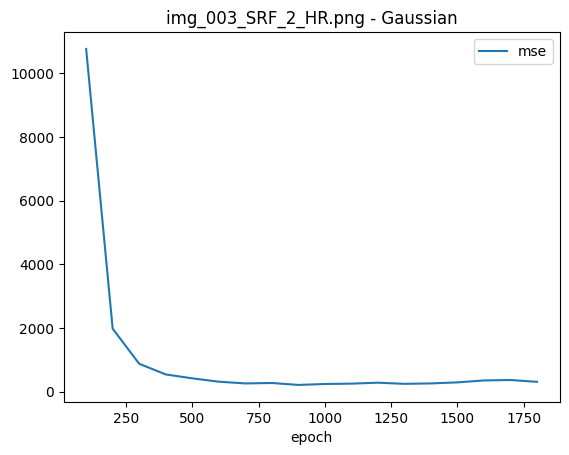

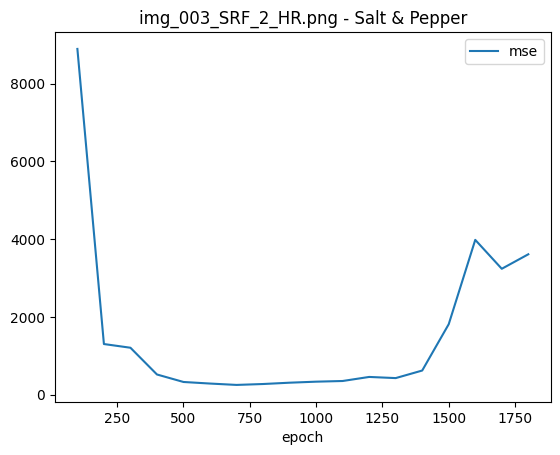

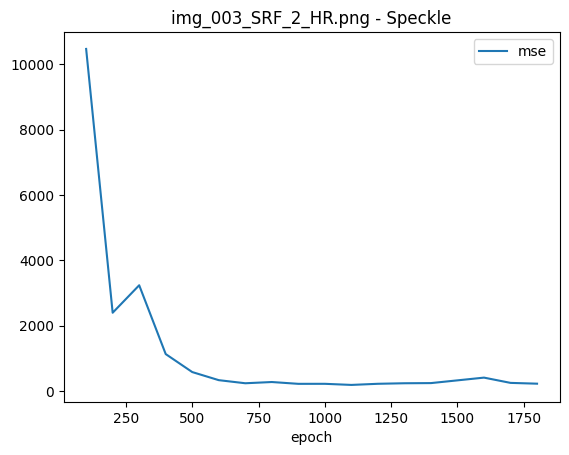

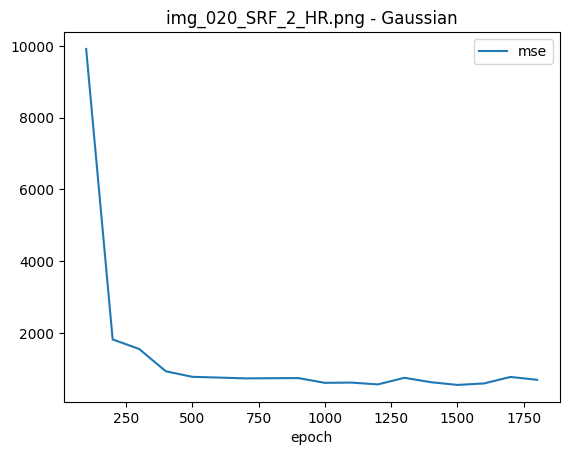

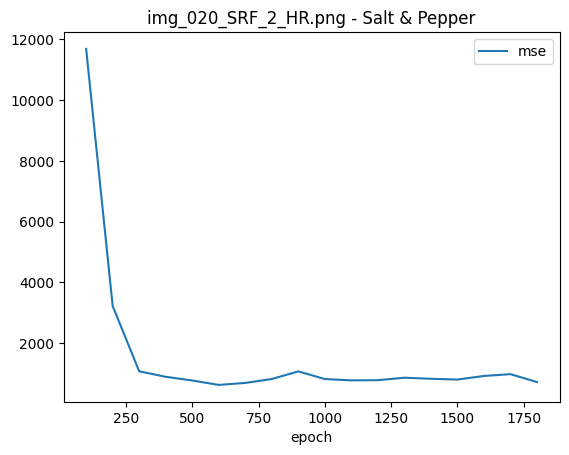

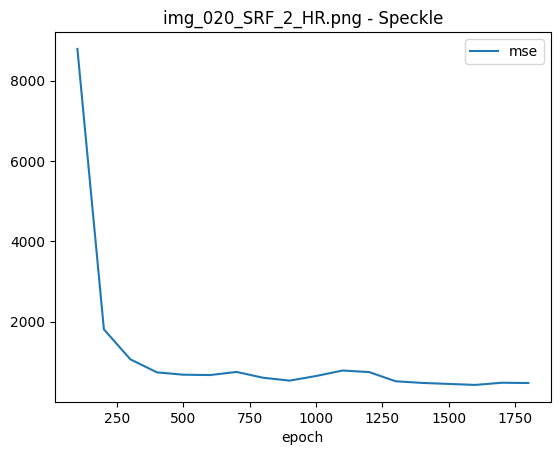

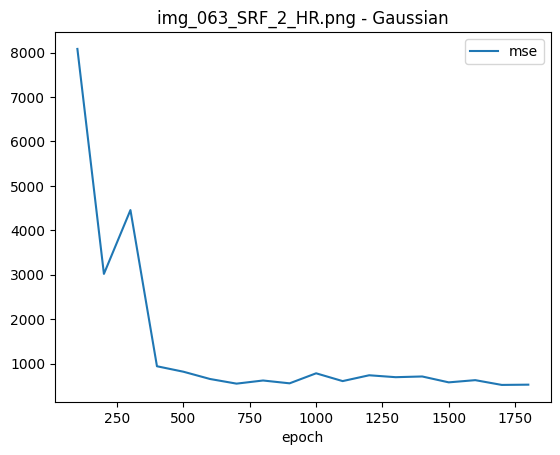

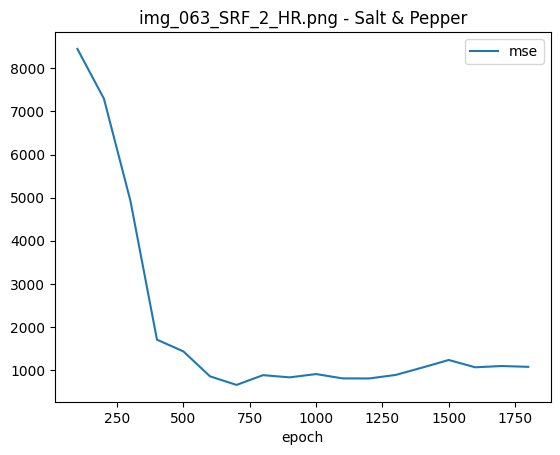

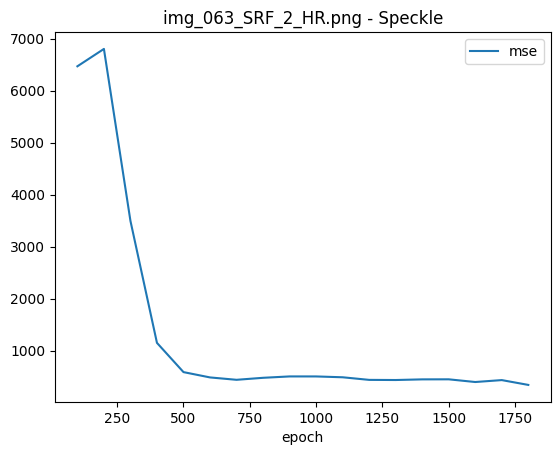

In [19]:
# MSE plots over epochs for each image

df.loc[(df["img_id"] == 2) & (df["noise_type"] == "gaussian")].sort_values(by="epoch").plot(x="epoch", y="mse", title="img_003_SRF_2_HR.png - Gaussian")
df.loc[(df["img_id"] == 2) & (df["noise_type"] == "s&p")].sort_values(by="epoch").plot(x="epoch", y="mse", title="img_003_SRF_2_HR.png - Salt & Pepper")
df.loc[(df["img_id"] == 2) & (df["noise_type"] == "speckle")].sort_values(by="epoch").plot(x="epoch", y="mse", title="img_003_SRF_2_HR.png - Speckle")

df.loc[(df["img_id"] == 19) & (df["noise_type"] == "gaussian")].sort_values(by="epoch").plot(x="epoch", y="mse", title="img_020_SRF_2_HR.png - Gaussian")
df.loc[(df["img_id"] == 19) & (df["noise_type"] == "s&p")].sort_values(by="epoch").plot(x="epoch", y="mse", title="img_020_SRF_2_HR.png - Salt & Pepper")
df.loc[(df["img_id"] == 19) & (df["noise_type"] == "speckle")].sort_values(by="epoch").plot(x="epoch", y="mse", title="img_020_SRF_2_HR.png - Speckle")

df.loc[(df["img_id"] == 62) & (df["noise_type"] == "gaussian")].sort_values(by="epoch").plot(x="epoch", y="mse", title="img_063_SRF_2_HR.png - Gaussian")
df.loc[(df["img_id"] == 62) & (df["noise_type"] == "s&p")].sort_values(by="epoch").plot(x="epoch", y="mse", title="img_063_SRF_2_HR.png - Salt & Pepper")
df.loc[(df["img_id"] == 62) & (df["noise_type"] == "speckle")].sort_values(by="epoch").plot(x="epoch", y="mse", title="img_063_SRF_2_HR.png - Speckle")